In [1]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns

sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, log_loss, accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.inspection import permutation_importance

# !conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

# !conda install -y -c conda-forge xgboost
import xgboost

pd.set_option('display.max_columns', 35)

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset = pd.read_excel('Dataset.xlsx')

In [3]:
dataset.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,ClaimSize
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21.0,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1.0,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,55526.069421
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4.0,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,59294.455571
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3.0,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,71756.941320
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65.0,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2.0,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,7584.153493
4,Feb,1,Saturday,Honda,Urban,Monday,Feb,3,Male,Married,36.0,Third Party,Sport - Collision,Sport,more than 69000,0,7,14,400,1.0,more than 30,more than 30,1,7 years,36 to 40,No,No,External,1 to 2,no change,1 vehicle,1994,Collision,98545.374339


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11565 entries, 0 to 11564
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 11565 non-null  object 
 1   WeekOfMonth           11565 non-null  int64  
 2   DayOfWeek             11565 non-null  object 
 3   Make                  11565 non-null  object 
 4   AccidentArea          11565 non-null  object 
 5   DayOfWeekClaimed      11565 non-null  object 
 6   MonthClaimed          11565 non-null  object 
 7   WeekOfMonthClaimed    11565 non-null  int64  
 8   Sex                   11565 non-null  object 
 9   MaritalStatus         11565 non-null  object 
 10  Age                   11560 non-null  float64
 11  Fault                 11565 non-null  object 
 12  PolicyType            11565 non-null  object 
 13  VehicleCategory       11565 non-null  object 
 14  VehiclePrice          11565 non-null  object 
 15  FraudFound_P       

In [5]:
dataset.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy', 'ClaimSize'],
      dtype='object')

In [6]:
dataset.nunique()

Month                      12
WeekOfMonth                 5
DayOfWeek                   7
Make                       19
AccidentArea                2
DayOfWeekClaimed            8
MonthClaimed               13
WeekOfMonthClaimed          5
Sex                         2
MaritalStatus               4
Age                        66
Fault                       2
PolicyType                  9
VehicleCategory             3
VehiclePrice                6
FraudFound_P                2
PolicyNumber            11565
RepNumber                  16
Deductible                  4
DriverRating                4
Days_Policy_Accident        5
Days_Policy_Claim           4
PastNumberOfClaims          4
AgeOfVehicle                8
AgeOfPolicyHolder           9
PoliceReportFiled           2
WitnessPresent              2
AgentType                   2
NumberOfSuppliments         4
AddressChange_Claim         5
NumberOfCars                5
Year                        3
BasePolicy                  3
ClaimSize 

In [7]:
print('Fraud class is %{:.2} of dataset ({} data points)'.format(
    np.mean(dataset.FraudFound_P) * 100,
    len(np.where(dataset.FraudFound_P == 1)[0])))

Fraud class is %5.9 of dataset (685 data points)


In [8]:
def printScores(model, X_test, y_test):
    print(f'{type(model).__name__}', 'on Test Data; Test F1: %.3f, Test AUC: %.3f, Log-Loss: %.3f' % \
      (f1_score(y_test, model.predict(X_test)), roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
       log_loss(y_test, model.predict_proba(X_test))))

    print()

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(dpi=150)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap=plt.cm.Blues,
                square=True,
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

# Logistic Regression

## Dimensionality Reduction

LogisticRegression on Test Data; Test F1: 0.028, Test AUC: 0.782, Log-Loss: 0.195

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2174
           1       0.40      0.01      0.03       137

    accuracy                           0.94      2311
   macro avg       0.67      0.51      0.50      2311
weighted avg       0.91      0.94      0.91      2311



<Figure size 900x600 with 0 Axes>

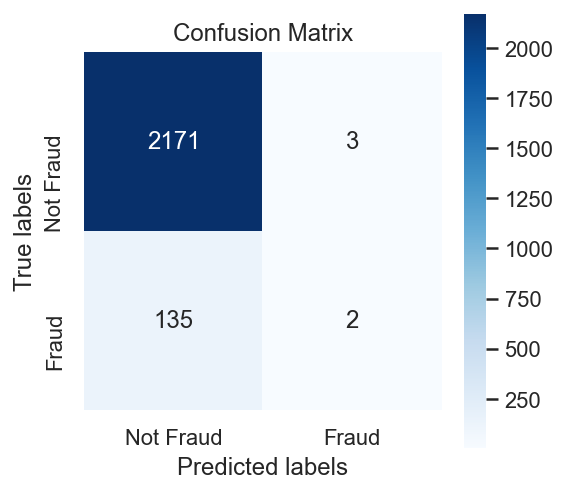

In [9]:
df2 = dataset.copy()

df2 = df2.dropna()

features_list = [
    'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'RepNumber', 'Deductible', 'DriverRating',
    'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
    'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent',
    'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy', 'ClaimSize'
]

X = df2.loc[:, features_list]
y = df2.loc[:, 'FraudFound_P'].values.ravel()

X.Sex = np.where(X.Sex == 'Male', 1, 0)
X = pd.get_dummies(X, drop_first=True)

# Linear dimensionality reduction using Singular Value Decomposition
pca = PCA(n_components='mle', whiten='True')
X = pca.fit(X).transform(X)

# Linear dimensionality reduction by means of truncated singular value decomposition
#svd = TruncatedSVD(n_components = 60)
#X = svd.fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    stratify=y,
                                                    random_state=101)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
printScores(lr, X_test, y_test)

LogisticRegression on Test Data; Test F1: 0.173, Test AUC: 0.783, Log-Loss: 0.265

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2174
           1       0.20      0.15      0.17       137

    accuracy                           0.91      2311
   macro avg       0.57      0.56      0.56      2311
weighted avg       0.90      0.91      0.91      2311



<Figure size 900x600 with 0 Axes>

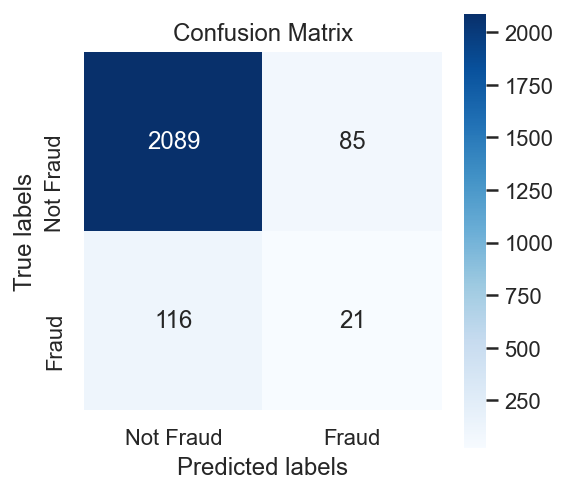

In [10]:
lr3 = LogisticRegression(C=1, max_iter=1000, class_weight={0: 0.2, 1: 0.8})
lr3.fit(X_train, y_train)
printScores(lr3, X_test, y_test)

LogisticRegression on Test Data; Test F1: 0.217, Test AUC: 0.783, Log-Loss: 0.400

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      2174
           1       0.13      0.58      0.22       137

    accuracy                           0.75      2311
   macro avg       0.55      0.67      0.54      2311
weighted avg       0.92      0.75      0.82      2311



<Figure size 900x600 with 0 Axes>

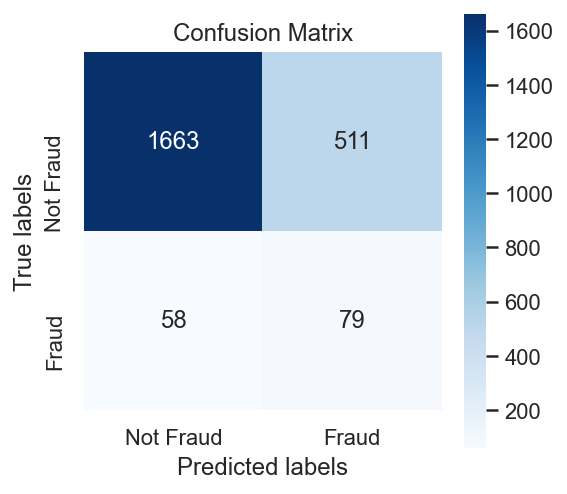

In [11]:
lr2 = LogisticRegression(C=1, max_iter=1000, class_weight={0: 0.1, 1: 0.9})
lr2.fit(X_train, y_train)
printScores(lr2, X_test, y_test)

## Handing Imbalanced Classes
Note: SMOTE is one of the famous oversampling techniques and is very effective in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques (ENN, Tomek) to increase the effectiveness of handling the imbalanced class.
- Over-sampling techniques: Oversampling techniques refer to create artificial minority class points. Some oversampling techniques are Random Over Sampling, ADASYN, SMOTE, etc.
- Under-sampling techniques: Undersampling techniques refer to remove majority class points. Some undersampling techniques are ENN, Random Under Sampling, TomekLinks, etc.
- https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn

__Summry:__ Dataset was:
- Over-sampled using Synthetic Minority Oversampling Technique (SMOTE)
- Over-sampled usign Adaptive Synthetic (ADASYN)
- Over-sampled using SMOTE and Under-sampled using TomekLinks __(This is the best performance)__
- Over-sampled using SMOTE and Under-sampled using ENN

PCA was also used along side oversampling and undersampling but it decreased performance

On Train Data:
LogisticRegression on Test Data; Test F1: 0.927, Test AUC: 0.977, Log-Loss: 0.195

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      8306
           1       0.93      0.92      0.93      8306

    accuracy                           0.93     16612
   macro avg       0.93      0.93      0.93     16612
weighted avg       0.93      0.93      0.93     16612

On Test Data:
LogisticRegression on Test Data; Test F1: 0.924, Test AUC: 0.975, Log-Loss: 0.203

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2077
           1       0.93      0.92      0.92      2077

    accuracy                           0.92      4154
   macro avg       0.92      0.92      0.92      4154
weighted avg       0.92      0.92      0.92      4154



<Figure size 900x600 with 0 Axes>

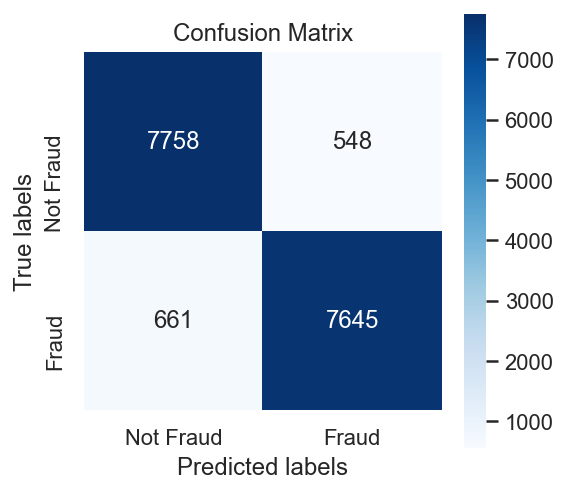

<Figure size 900x600 with 0 Axes>

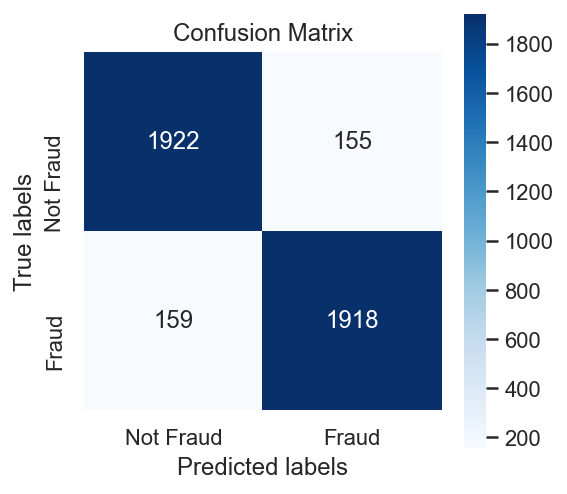

In [12]:
df3 = dataset.copy()

df3 = df3.dropna()

features_list = [
    'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'RepNumber', 'Deductible', 'DriverRating',
    'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
    'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent',
    'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy', 'ClaimSize'
]

X2 = df3.loc[:, features_list]
y2 = df3.loc[:, 'FraudFound_P'].values.ravel()

X2.Sex = np.where(X2.Sex == 'Male', 1, 0)
X2 = pd.get_dummies(X2, drop_first=True)

# Linear dimensionality reduction using Singular Value Decomposition
#pca = PCA(n_components='mle', whiten='True')
#X2 = pca.fit(X2).transform(X2)

# Linear dimensionality reduction by means of truncated singular value decomposition
#svd = TruncatedSVD(n_components = 60)
#X2 = svd.fit(X2).transform(X2)

#### Synthetic Minority Oversampling Technique (SMOTE): to over-sample minority classes
#X2_resampled,y2_resampled = SMOTE(random_state = 3).fit_resample(X2,y2)

#### Adaptive Synthetic (ADASYN) sampling method: to over-sample minority classes
#X2_resampled,y2_resampled = ADASYN(random_state = 3).fit_resample(X2,y2)

#### Over-sampling using SMOTE and cleaning using Tomek links
X2_resampled, y2_resampled = SMOTETomek(random_state=3).fit_resample(X2, y2)

#### Over-sampling using SMOTE and cleaning using ENN algorithm
#X2_resampled,y2_resampled = SMOTEENN(random_state=3).fit_resample(X2,y2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2_resampled,
                                                        y2_resampled,
                                                        test_size=.2,
                                                        stratify=y2_resampled,
                                                        random_state=101)

lr4 = LogisticRegression(max_iter=1000)
lr4.fit(X2_train, y2_train)
print("On Train Data:")
printScores(lr4, X2_train, y2_train)
print("On Test Data:")
printScores(lr4, X2_test, y2_test)

In [13]:
len(X2_resampled), len(X2), len(X2_resampled)/len(X2)

(20766, 11554, 1.7972996364895275)

In [14]:
print('Fraud class after resampling is %{}'.format(np.mean(y2_resampled)*100))

Fraud class after resampling is %50.0


In [15]:
#pca.explained_variance_ratio_, len(pca.explained_variance_ratio_), pca.explained_variance_ratio_.sum()

<AxesSubplot:>

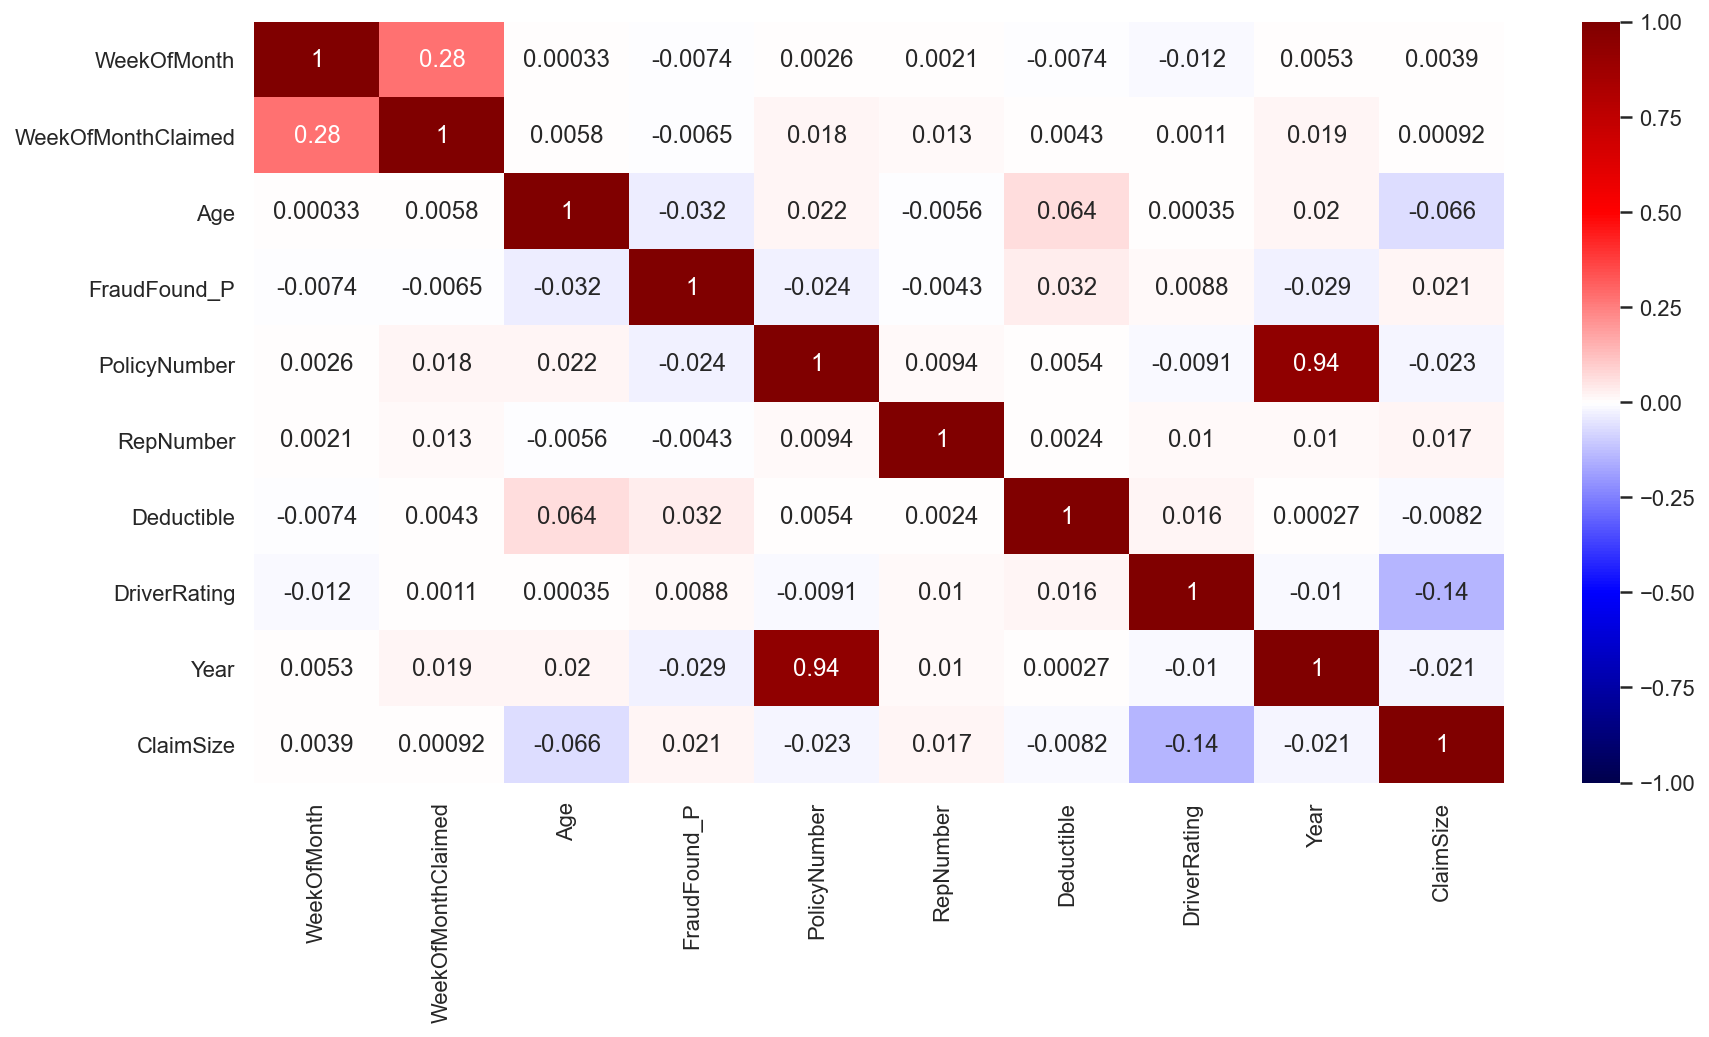

In [16]:
plt.figure(figsize=(14, 7))
sns.heatmap(dataset.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

Text(0.5, 0, 'Permutation Importance')

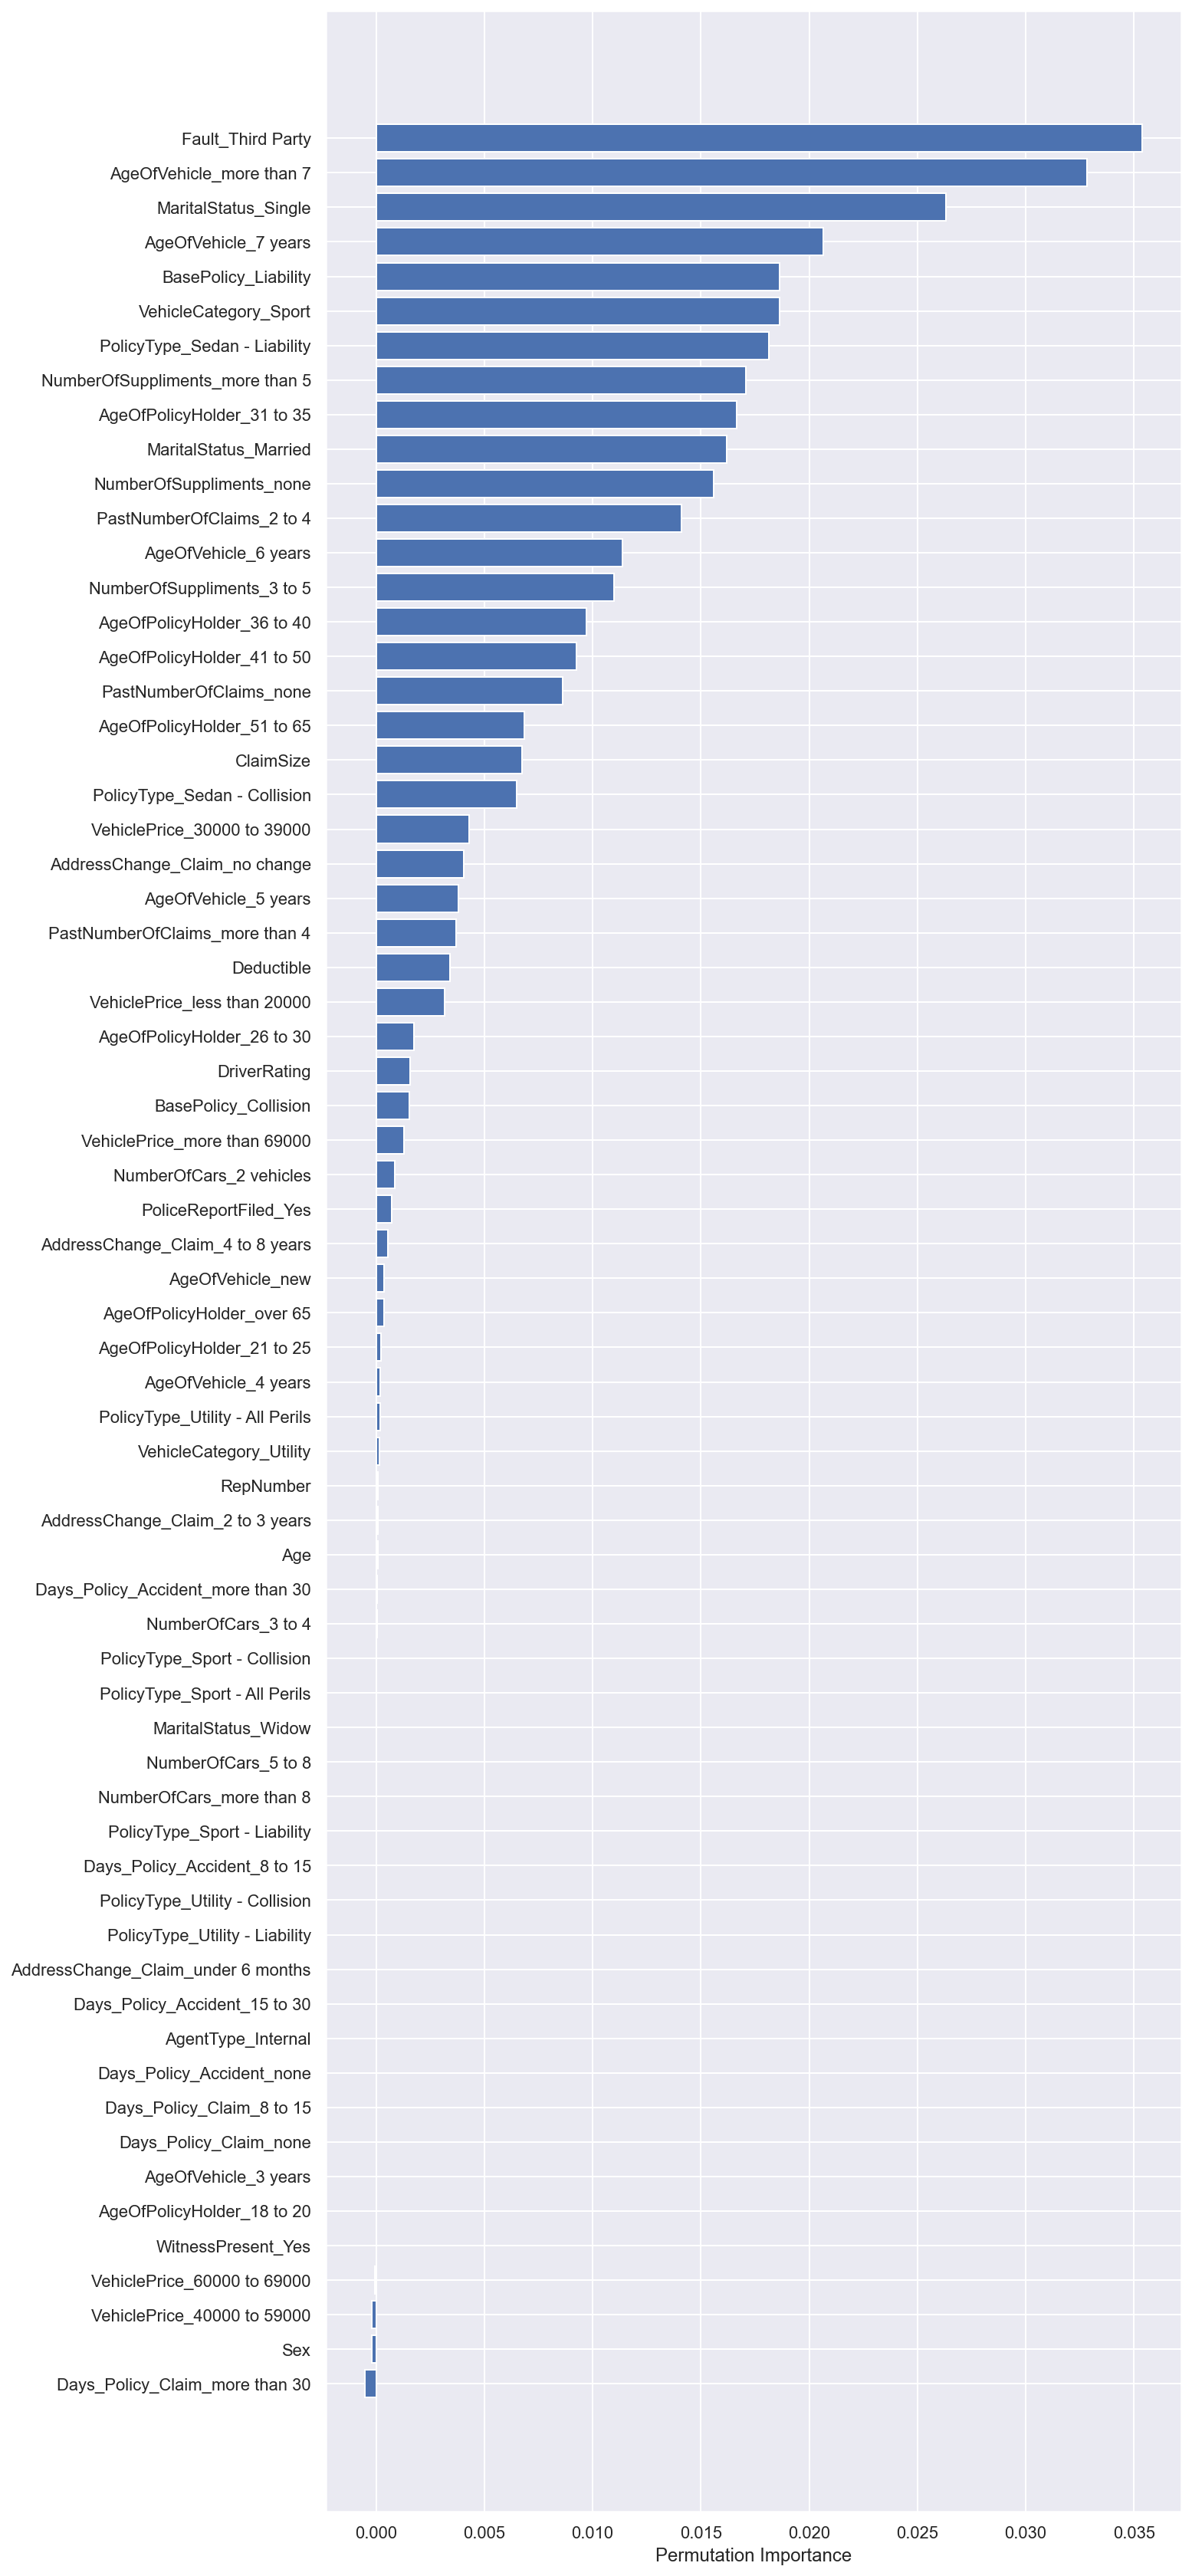

In [17]:
plt.figure(figsize=(10, 30))
perm_importance = permutation_importance(lr4, X2_test, y2_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X2_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# k-Nearest Neighbors

KNeighborsClassifier on Test Data; Test F1: 0.883, Test AUC: 0.947, Log-Loss: 0.488

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1264
           1       0.86      0.90      0.88      1630

    accuracy                           0.87      2894
   macro avg       0.87      0.86      0.86      2894
weighted avg       0.87      0.87      0.86      2894



<Figure size 900x600 with 0 Axes>

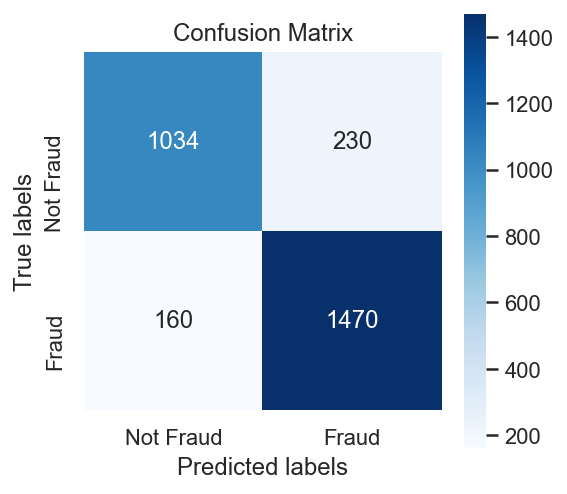

In [18]:
df6 = dataset.copy()

df6 = df6.dropna()

features_list = [
    'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'RepNumber', 'Deductible', 'DriverRating',
    'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
    'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent',
    'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy', 'ClaimSize'
]

X6 = df6.loc[:, features_list]
y6 = df6.loc[:, 'FraudFound_P'].values.ravel()

X6.Sex = np.where(X6.Sex == 'Male', 1, 0)
X6 = pd.get_dummies(X6, drop_first=True)

#### Over-sampling using SMOTE and cleaning using ENN (Edited Nearest Neighbours) algorithm
X6_resampled, y6_resampled = SMOTEENN(random_state=3).fit_resample(X6, y6)

X6_train, X6_test, y6_train, y6_test = train_test_split(X6_resampled,
                                                        y6_resampled,
                                                        test_size=.2,
                                                        stratify=y6_resampled,
                                                        random_state=101)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X6_train, y6_train)
printScores(knn, X6_test, y6_test)

# Random Forest

## using SMOTE + Tomek links

RandomForestClassifier on Test Data; Test F1: 0.965, Test AUC: 0.990, Log-Loss: 0.146

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2077
           1       0.98      0.95      0.97      2077

    accuracy                           0.97      4154
   macro avg       0.97      0.97      0.97      4154
weighted avg       0.97      0.97      0.97      4154



<Figure size 900x600 with 0 Axes>

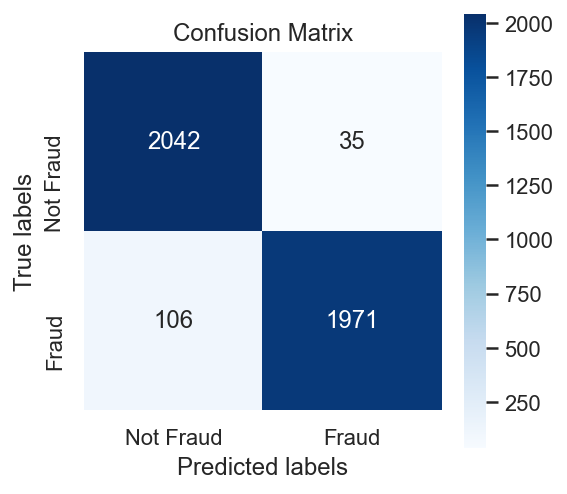

In [19]:
df4 = dataset.copy()

df4 = df4.dropna()

features_list = [
    'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'RepNumber', 'Deductible', 'DriverRating',
    'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
    'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent',
    'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy', 'ClaimSize'
]

X3 = df4.loc[:, features_list]
y3 = df4.loc[:, 'FraudFound_P'].values.ravel()

X3.Sex = np.where(X3.Sex == 'Male', 1, 0)
X3 = pd.get_dummies(X3, drop_first=True)

X3_resampled, y3_resampled = SMOTETomek(random_state=3).fit_resample(X3, y3)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3_resampled,
                                                        y3_resampled,
                                                        test_size=.2,
                                                        stratify=y3_resampled,
                                                        random_state=101)

RC = RandomForestClassifier(n_estimators=1000, max_features=30, random_state=50)

RC.fit(X3_train, y3_train)
printScores(RC, X3_test, y3_test)

## using RandomizedSearchCV

In [20]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Fitting 3 folds for each of 100 candidates, totalling 300 fits

In [21]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X3_train, y3_train)

In [22]:
#rf_random.best_params_
rf_random_best_params = {
    'n_estimators': 1400,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 80,
    'bootstrap': False
}

RandomForestClassifier on Test Data; Test F1: 0.965, Test AUC: 0.990, Log-Loss: 0.122

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2077
           1       0.99      0.94      0.97      2077

    accuracy                           0.97      4154
   macro avg       0.97      0.97      0.97      4154
weighted avg       0.97      0.97      0.97      4154



<Figure size 900x600 with 0 Axes>

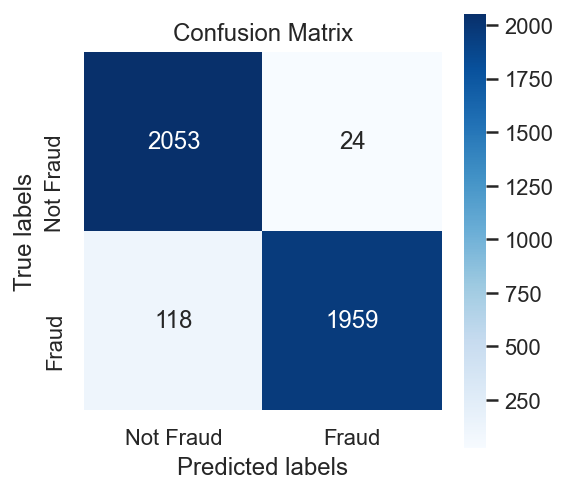

In [23]:
RC2 = RandomForestClassifier(**rf_random_best_params)
RC2.fit(X3_train, y3_train)
printScores(RC2, X3_test, y3_test)

Text(0.5, 0, 'Random Forest Feature Importance')

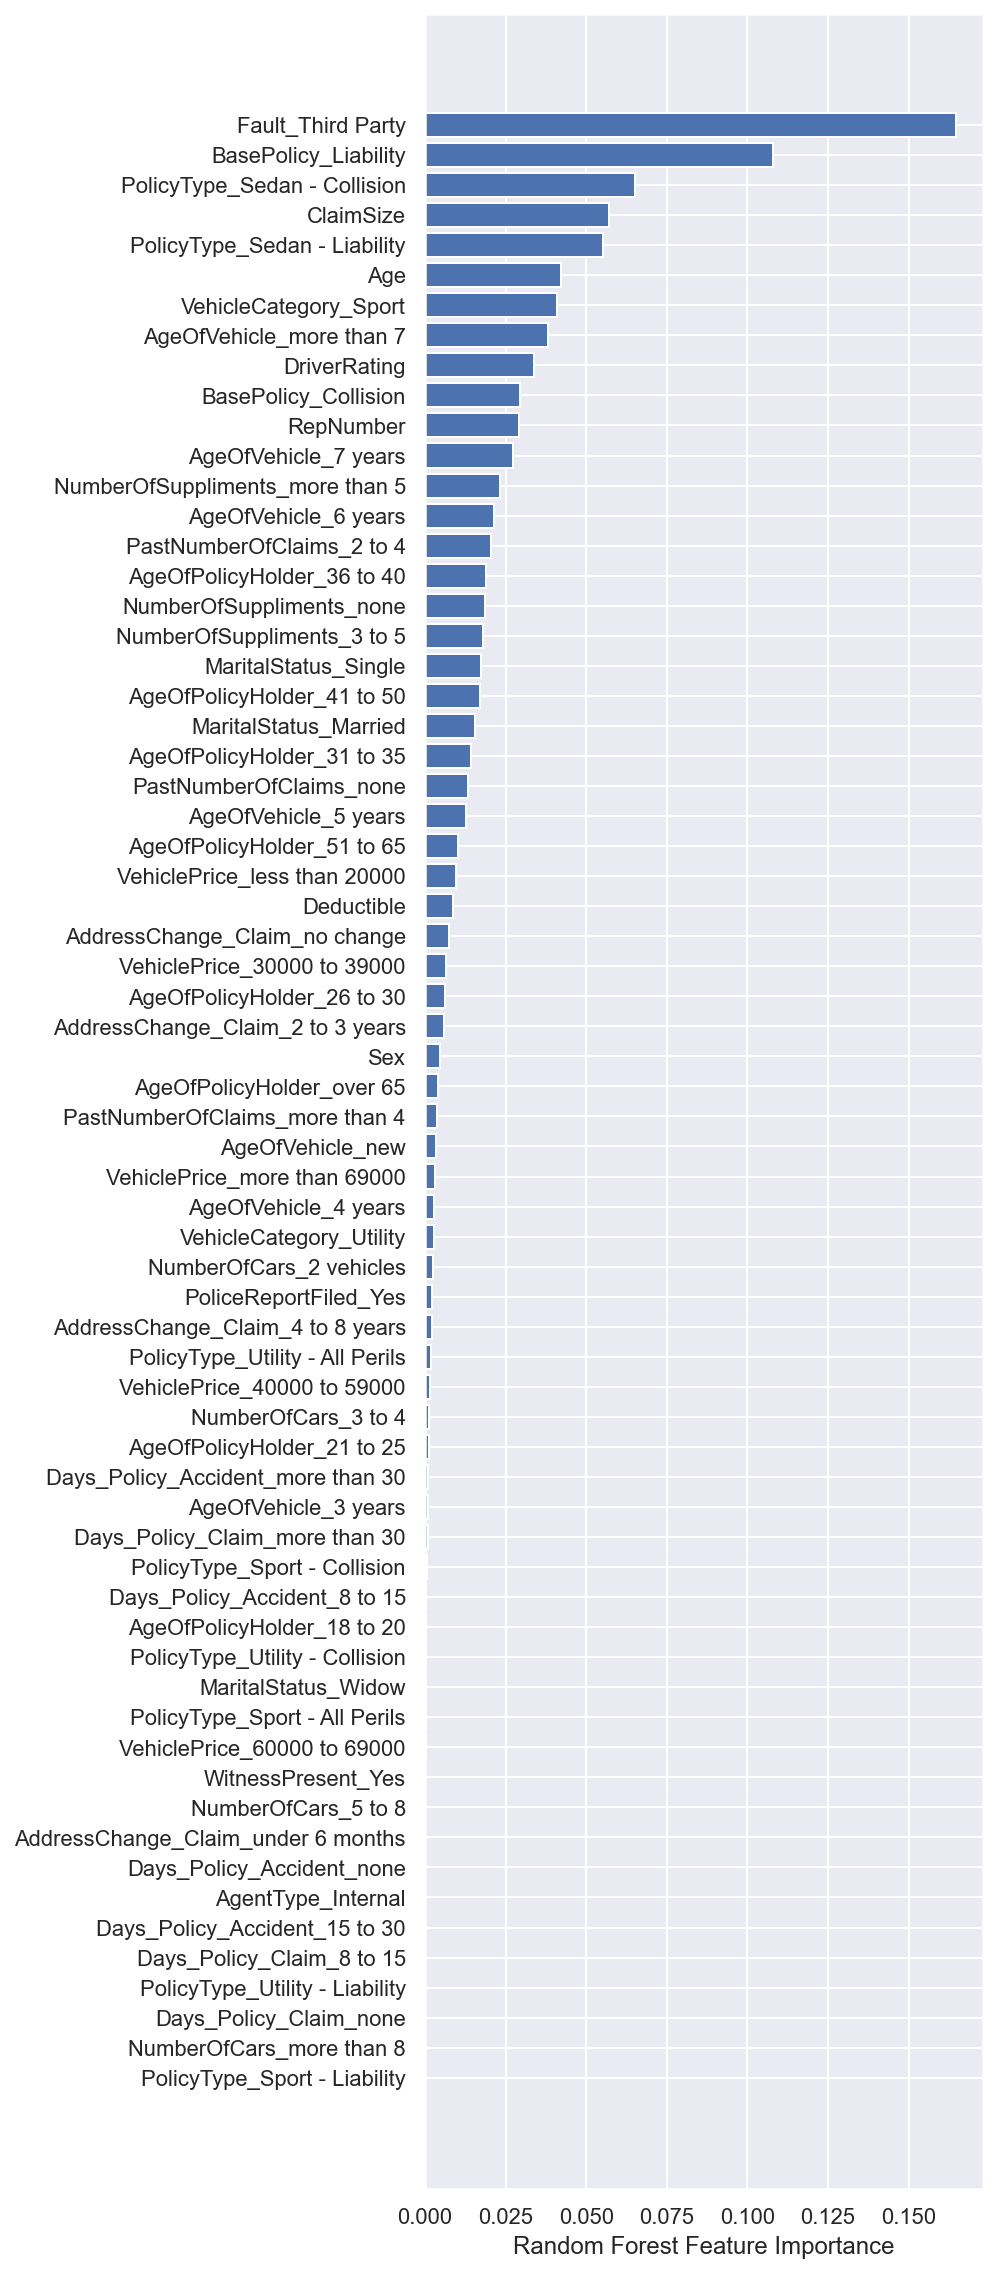

In [24]:
plt.figure(figsize(5,20))
sorted_idx = RC.feature_importances_.argsort()
plt.barh(X3.columns[sorted_idx], RC.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [25]:
#plt.figure(figsize=(10, 30))
#perm_importance2 = permutation_importance(RC, X3_test, y3_test)
#sorted_idx = perm_importance2.importances_mean.argsort()
#plt.barh(X3_test.columns[sorted_idx], perm_importance2.importances_mean[sorted_idx])
#plt.xlabel("Permutation Importance")

# xgboost - GradientBoostedTrees

Accuracy 0.944
XGBClassifier on Test Data; Test F1: 0.097, Test AUC: 0.803, Log-Loss: 0.359

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2174
           1       1.00      0.05      0.10       137

    accuracy                           0.94      2311
   macro avg       0.97      0.53      0.53      2311
weighted avg       0.95      0.94      0.92      2311



<Figure size 750x3000 with 0 Axes>

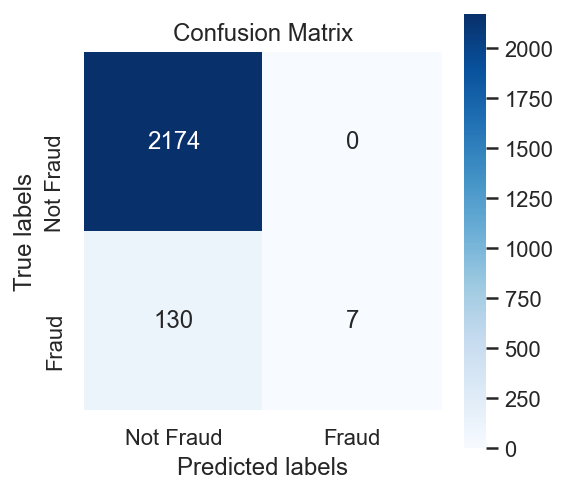

In [26]:
df5 = dataset.copy()

df5 = df5.dropna()

features_list = [
    'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'RepNumber', 'Deductible', 'DriverRating',
    'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
    'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent',
    'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy', 'ClaimSize'
]

X5 = df5.loc[:, features_list]
y5 = df5.loc[:, 'FraudFound_P'].values.ravel()

X5.Sex = np.where(X5.Sex == 'Male', 1, 0)
X5 = pd.get_dummies(X5, drop_first=True)

X5_train, X5_test, y5_train, y5_test = train_test_split(X5,
                                                        y5,
                                                        test_size=.2,
                                                        stratify=y5,
                                                        random_state=101)

gbm = xgboost.XGBClassifier(
    n_estimators=30000,
    max_depth=4,
    objective='binary:logistic',  #new objective
    learning_rate=.05,
    subsample=.8,
    min_child_weight=3,
    colsample_bytree=.8,
    use_label_encoder=False)

eval_set = [(X5_train, y5_train), (X5_test, y5_test)]
fit_model = gbm.fit(
    X5_train,
    y5_train,
    eval_set=eval_set,
    eval_metric=
    'error',  #new evaluation metric: classification error (could also use AUC, e.g.)
    early_stopping_rounds=50,
    verbose=False)

print('Accuracy %.3f' % accuracy_score(
    y5_test, gbm.predict(X5_test, ntree_limit=gbm.best_ntree_limit)))
printScores(gbm, X5_test, y5_test)

## using GridSearchCV to searche different class weights

In [27]:
XGBclf = xgboost.XGBClassifier(use_label_encoder=False)

weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=XGBclf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

#grid_result = grid.fit(X5_train, y5_train)
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

XGBClassifier on Test Data; Test F1: 0.123, Test AUC: 0.800, Log-Loss: 0.202

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2174
           1       0.38      0.07      0.12       137

    accuracy                           0.94      2311
   macro avg       0.66      0.53      0.55      2311
weighted avg       0.91      0.94      0.92      2311



<Figure size 750x3000 with 0 Axes>

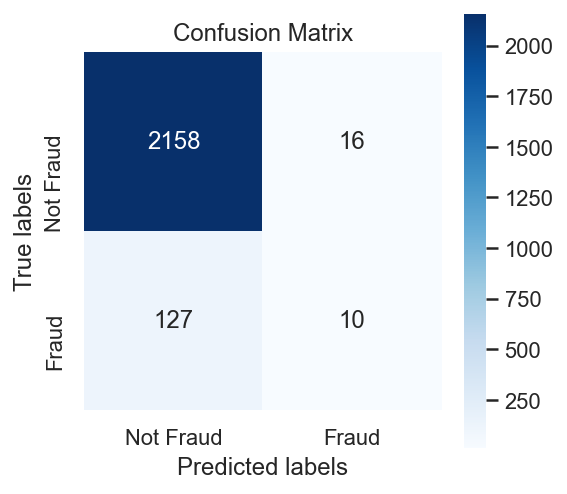

In [28]:
XGBclf2 = xgboost.XGBClassifier(scale_pos_weight= 1, eval_metric='logloss',use_label_encoder=False)
XGBclf2.fit(X5_train, y5_train)
printScores(XGBclf2, X5_test, y5_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

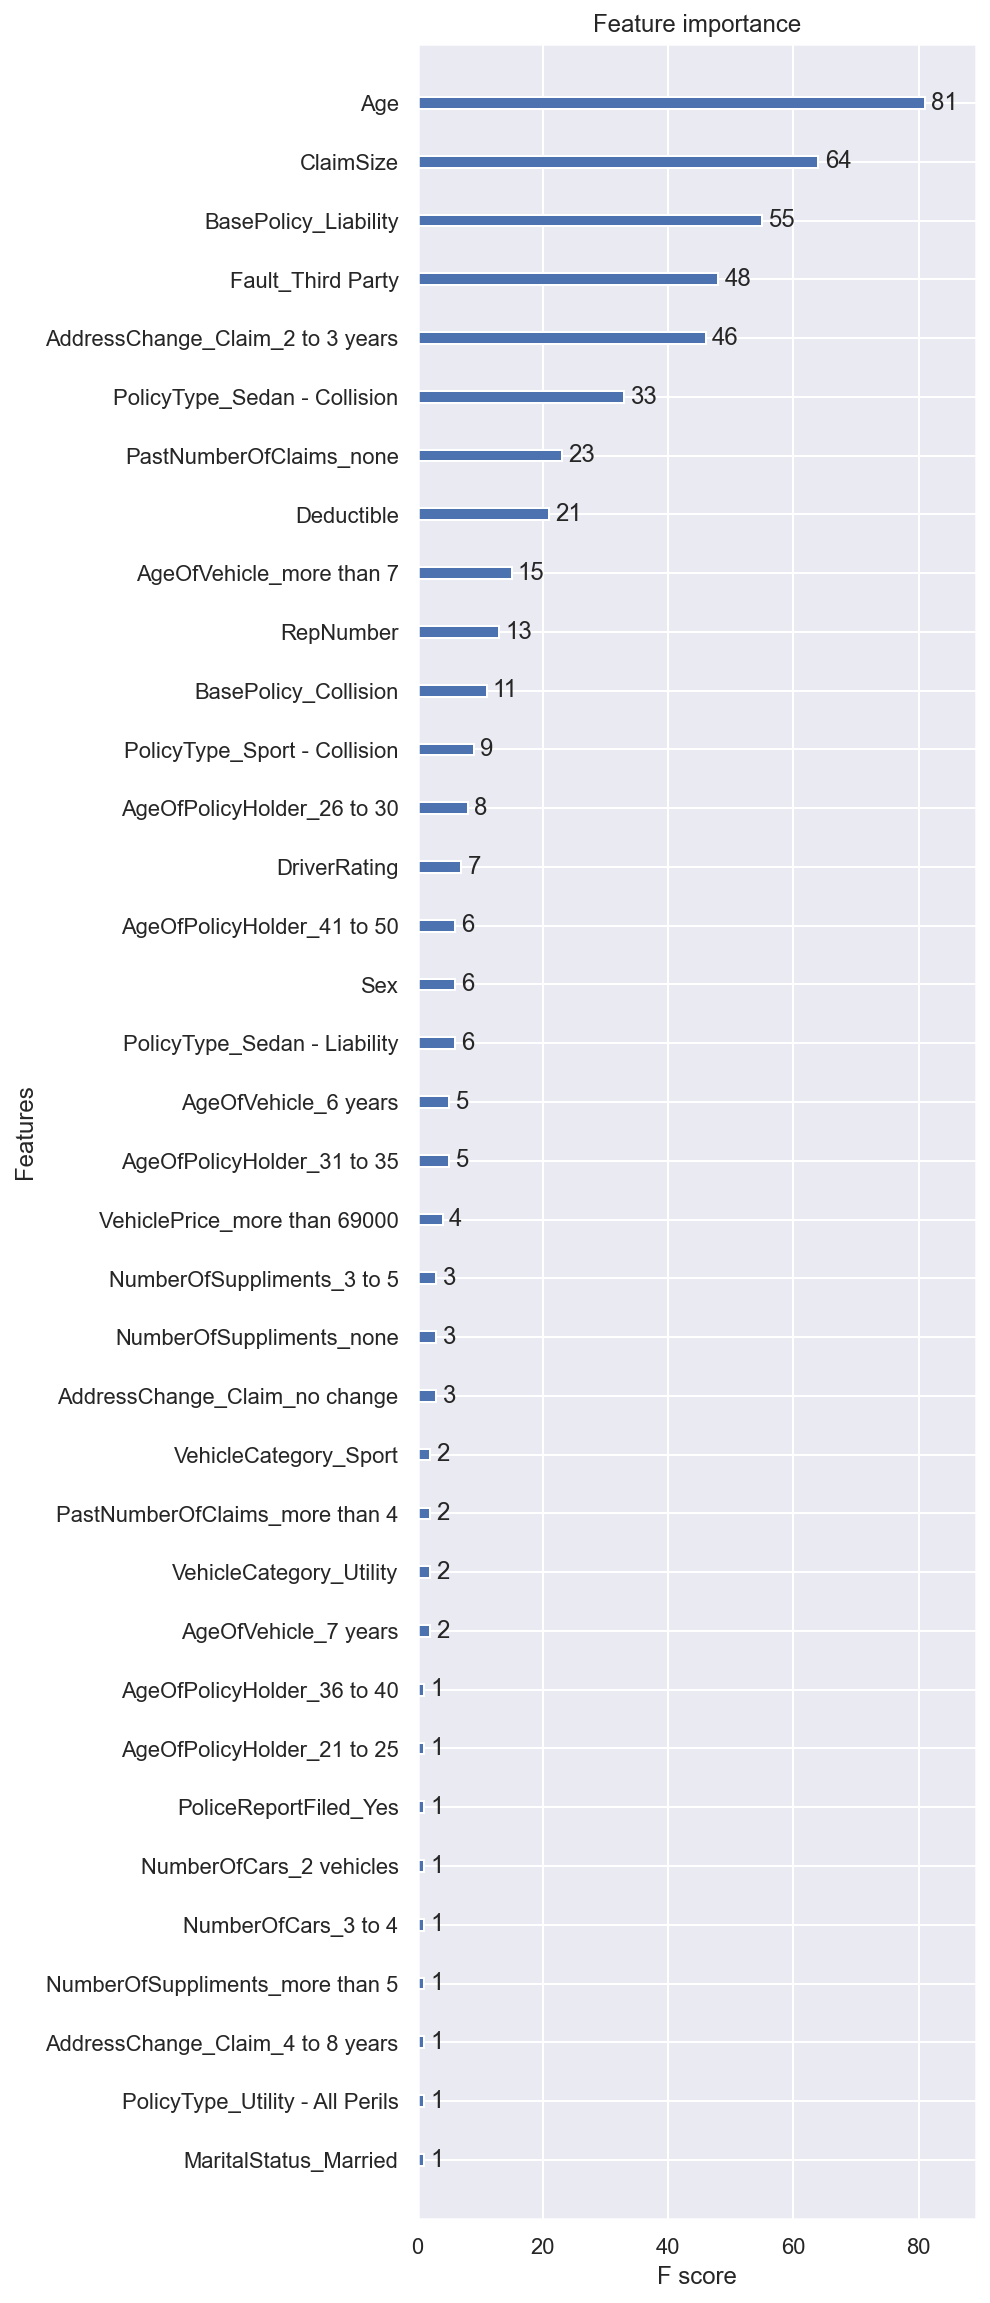

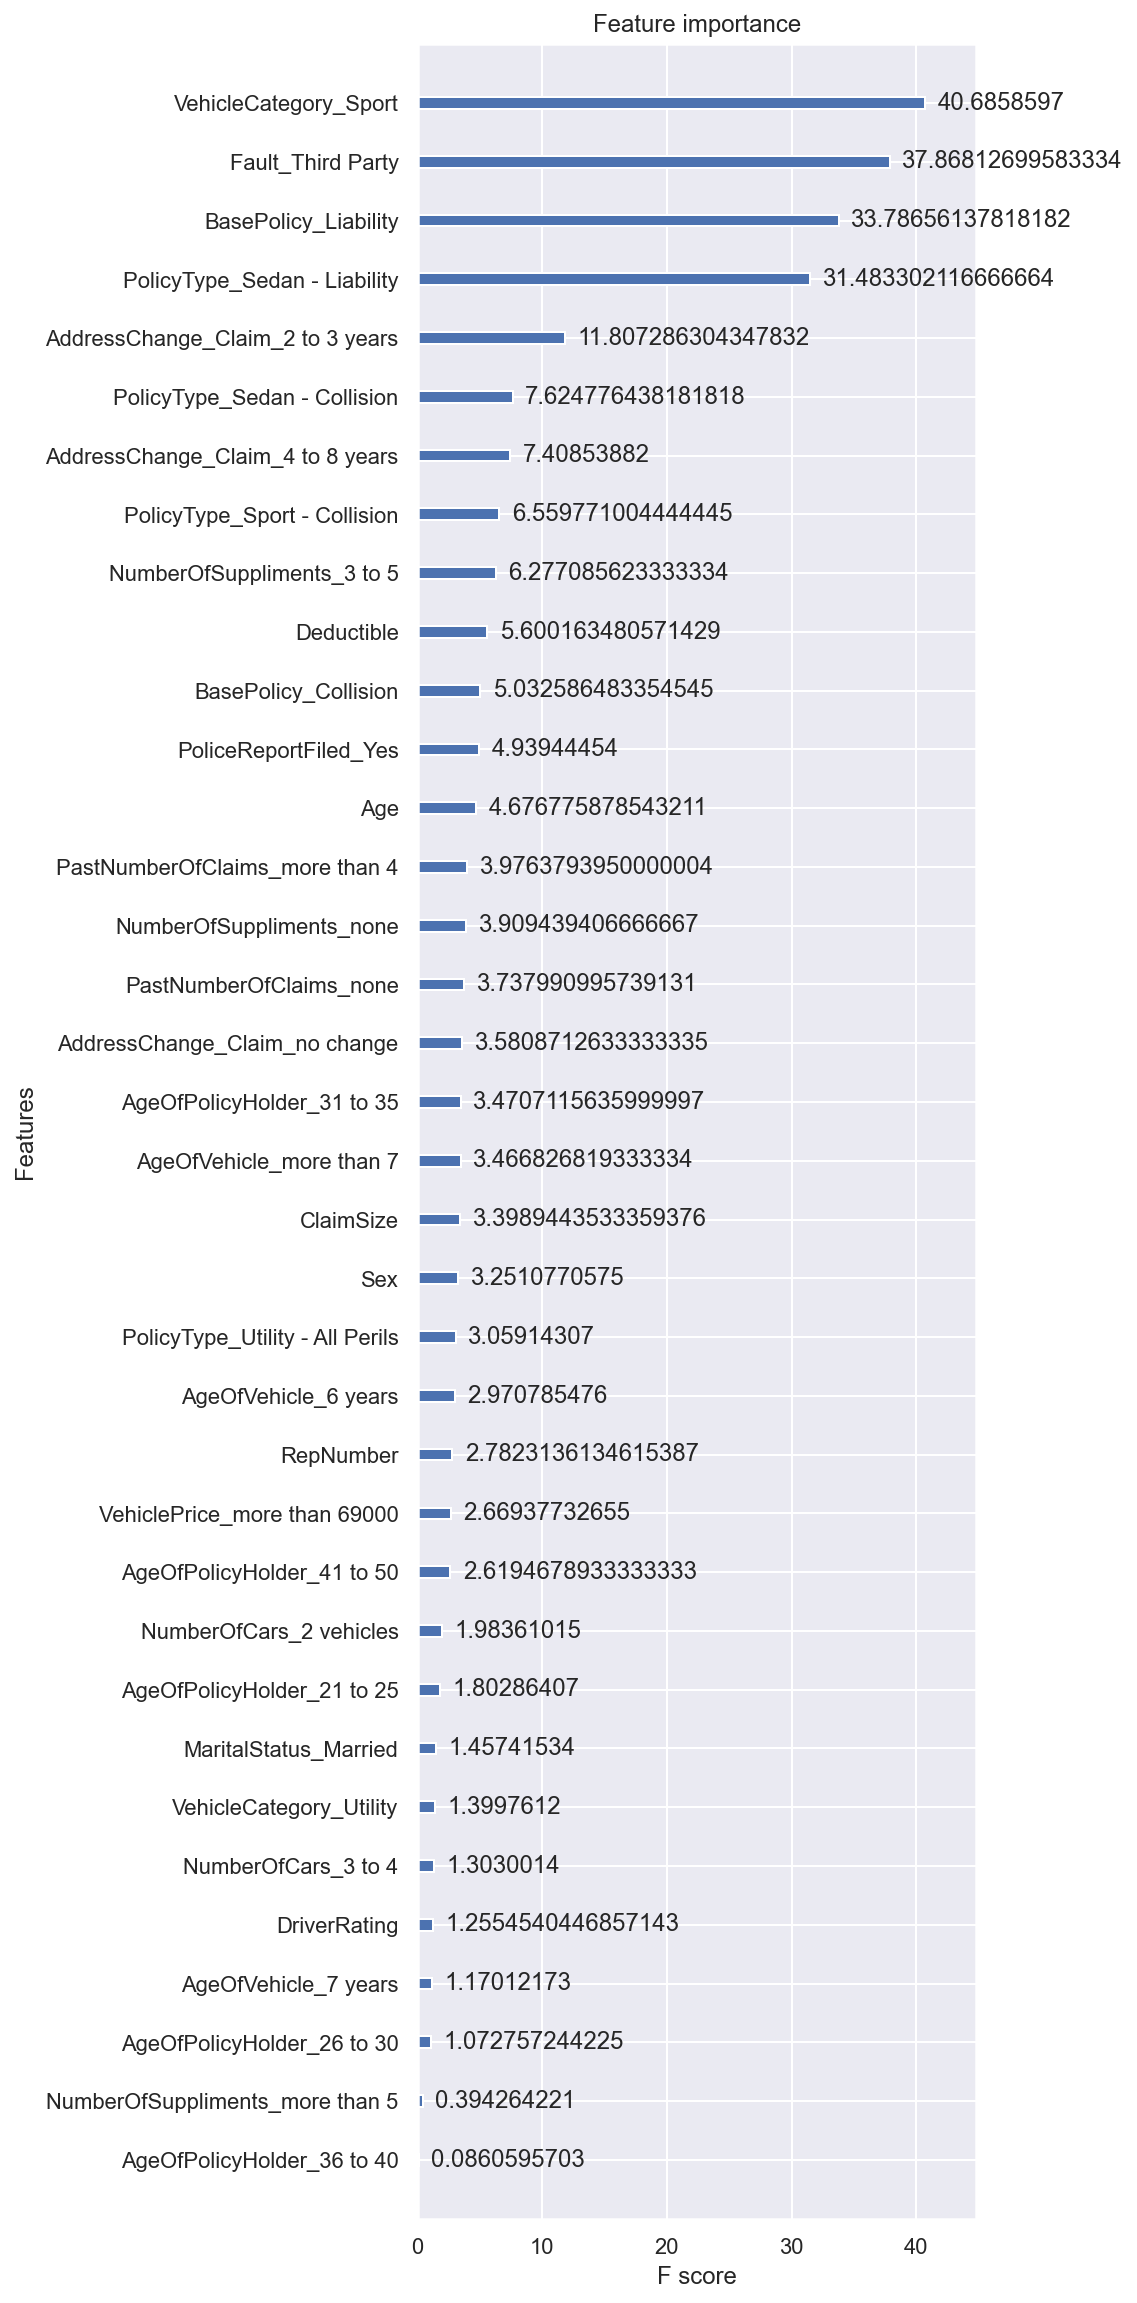

In [29]:
figsize(5,20)
xgboost.plot_importance(gbm)
xgboost.plot_importance(gbm, importance_type='gain')